# RANDOM FOREST REGRESSOR.

Random forest algorithm is a supervised machine learning technique that uses decision tree as its base for prediction. It ensembles multiple decision trees together and aggregates/votes values to estimate the values. When training each estimator, it introduces random trees that run parallel and do not interact with each other during tree building. This model can perform both classification and regression but we are going to test the latter. 

By combining multiple models, this algorithm achieves higher prediction accuracy and optimisation by reducing variance across models. Random forest uses bagging technique(ensemble type) where multiple models run independently in parrallel then their values averged to give an outcome. Boosting on the other end learns sequentially and corrects errors at each step to imrove stability of a model. It adapts to the model.  

Random forest regressor learns by building many decision tress, mostly 100's, then finds the average regression of all trees. Original data is brocken into small subsets (tuples) iteratively, in each, an observation is selected through row sampling with replacement method (boostraping). A model is then created and learns from each training sample and then returns an outcome. The model then counts all values and the one having most occurance is assigned to an unknown value X, this is bagging.  Individual decision trees have high varaiance, but when they are combined in parrallel then the resulting variance is greatly reduced since each model is trained perfectly on different  sample data. Accuracy is higher becaused a decision is pegged on multiple models (no dependence on a single model). 

Random Forest is generally more accurate and robust than regression. It is also less prone to overfitting because it emphasises on the element of randomness which means that it is more likely to generalize well to new data. This also ensures that the tree are NOT correlated as much as possible. 

Random forests is designed to handle shortfalls from decision tree, this includes ;

- Decision trees are prone to overfitting because of high variances in single models. With random forests, variance is reduced by running and ensemble of decisions tree models.
- Decision tree model is highly sensitive, minor changes in the original data can give a completly different prediction making them very unstable.  




Like any other machine learning process, the steps are as follows ;

1. Define a problem - predict US election voter turnout for the 2020.
2. Access data in the appropriate format for python language 
3. Study the data to correct anomalies such as missing values that may hinder you from achieving the objective.
4. Create a machine learning model, random forest regressor will be used.
5. Train the model to understand relationship betweem predictor and target variables. 
6. Test your model and evaluate performance. 
7. Refine your model to suite your objectives - get more data, use a different technique, add parameters.
8. Finally interpret the data gained and report as needed. 


We need an algorithm that will predict the voter turnout for the year 2020 election based on independent variables such as previous turnout , income and age all aggregated at county level. 

In [1]:
# Import Required libraries. 
import pandas as pd 
import geopandas as gpd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Distance measurements 
from shapely.geometry import LineString

# Machine learning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score  # Evaluating the model

# 1. Data Preparation.

In [2]:
# Load data 

path = 'F:/Programs/Secrets of ML/Data/US_Elections.gpkg'

# Read data containing county polygons. 
data = gpd.read_file(path, layer='US_CountyElections_clean')


# Create New dataframes 
# States, dissolve counties based on column with state abbreviation
states = data.dissolve(by='state_abbr', aggfunc='sum')

# Regions , dissolve counties based on their region column
regions = data.dissolve(by='region', aggfunc='sum')


# Read cities data, points data layers  
cities_10 = gpd.read_file(path, layer='US_Cities10')      # Class 10 cities 
cities_9 = gpd.read_file(path, layer='US_Cities9')        # Class 9 cities 
cities_8 = gpd.read_file(path, layer='US_Cities8')        # Class 8 cities 


# Data characteristics 
print(f'County data ------> shape : {data.shape}   ||  Projection : {data.crs} \n Columns : {data.columns } \n----------------\n\
       City 10 data ------> Shape : {cities_10.shape}   ||   Projection : {cities_10.crs} \n \
       data columns: {cities_10.columns}')


County data ------> shape : (3108, 18)   ||  Projection : EPSG:3857 
 Columns : Index(['county_FIPS', 'name', 'population', 'state_abbr', 'state_fips',
       'state_name', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
       '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'region', 'geometry'],
      dtype='object') 
----------------
       City 10 data ------> Shape : (10, 7)   ||   Projection : EPSG:3857 
        City data columns: Index(['CLASS', 'STFIPS', 'city_FIPS', 'POP_CLASS', 'POPULATION', 'POP2010',
       'geometry'],
      dtype='object')


C:\Users\Admin\AppData\Local\Temp\ipykernel_7224\2733668405.py:13: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(title = "Legend", fontsize="15", loc='lower left') # Legend


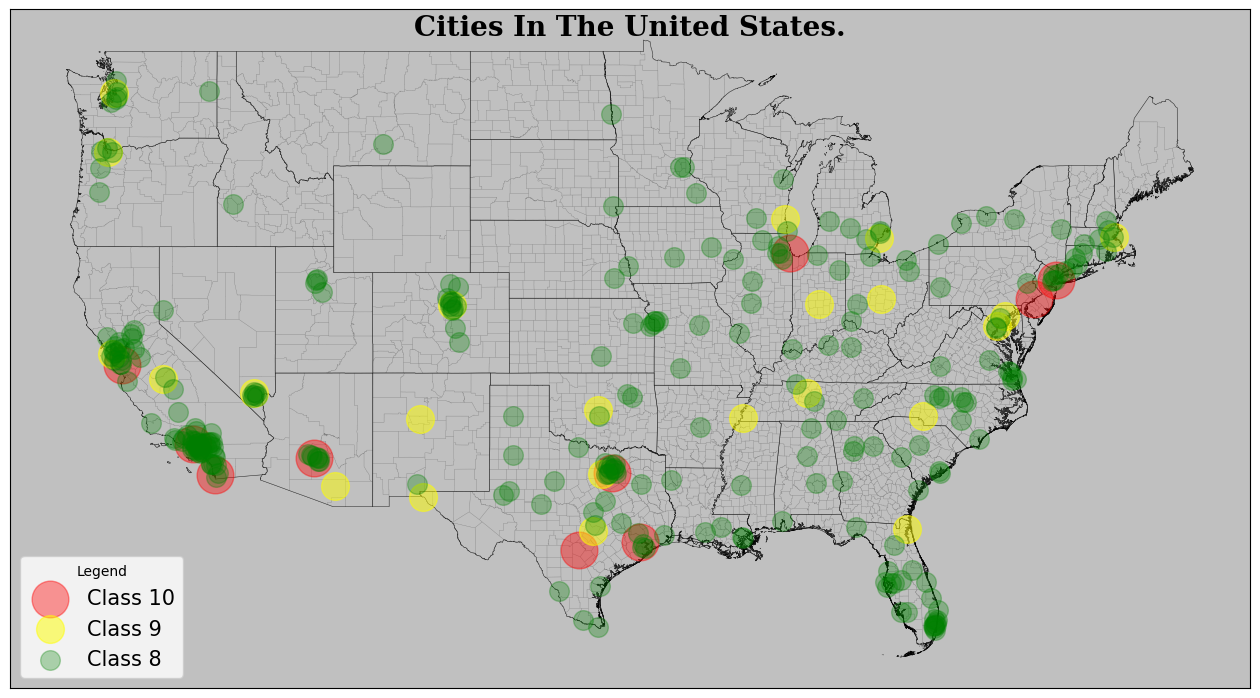

In [3]:
# Visualise data by ploting on a map  

# Initiate plot
fig, ax = plt.subplots(figsize=(16, 12))

# Add various features 
data.plot(ax=ax, color='#C0C0C0', edgecolor='black', linewidth=0.2, alpha=0.6)
states.plot(ax=ax, color='#C0C0C0', edgecolor='black', linewidth=0.4, alpha=0.6, label='states')
cities_10.plot(ax=ax, marker='o', color='red', markersize = 700, alpha=0.4, label='Class 10')
cities_9.plot(ax=ax, marker='o', color='yellow', markersize=400, alpha=0.5, label='Class 9')
cities_8.plot(ax=ax, marker='o', color='green', markersize=200, alpha=0.3, label='Class 8')

plt.legend(title = "Legend", fontsize="15", loc='lower left') # Legend
plt.title("Cities In The United States.", fontsize=20, fontweight='bold', 
          fontfamily='serif', y=0.95, color='black')  # Title 
                                                     
# get current axes
ax = plt.gca()
ax.get_xaxis().set_visible(False)   #hide x-axis
ax.get_yaxis().set_visible(False)    #hide y-axis 
ax.set_facecolor('#C0C0C0')  # Background colour of plot area
plt.show()


# 2. Feature Engineering. 

Machine learning models are dependent on features used to train them. A terrible feature will have a negative impact resulting to inadequate models. Feature engineering allows data to be refined by creating new features from existing models. This is aimed at simplifying data and transforming models thus improving perfomance and accuracy. 

Our data contains the population for each county polygon, by defining population density within a geographic region, we will asses the changes on the algorithm. 

                Pop density = Popultion / Area

We also intend to add a proximity to city variable, distance variable that describes the urban and rural characteristics of a county. Cities in the US are classified based on population, i.e cities 10 are more populous than cities 8. We need to determine the distance between a county to each class of a city, rural counties are located far while urban ones are closer to cities. Distance will be determined by calculating the ellipsoidal distance from the center of a polygon to the closest city in all classes. A county will have 3 variables representing distances to cities of class 10, 8 and 7.


## 2.1 Population Density Feature.

Using geopandas modile the area for each county is calculated then used to find population density. 

<Axes: >

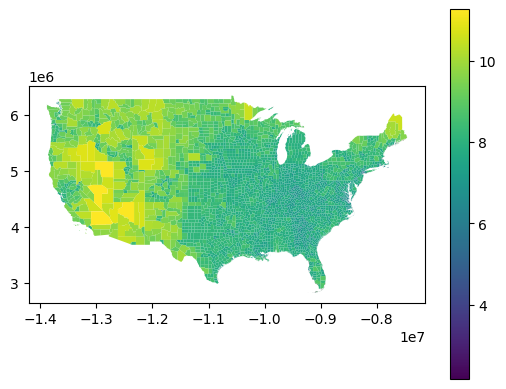

In [4]:
# Add area column in km square, crs must be in projected coordinate system
sample = data.copy()

# Standardize column to have a non biased map
data['area_sq_KM'] = np.log(data['geometry'].area/ 10**6)

data.plot(column='area_sq_KM', legend=True)

## 2.2 Proximity Analysis.

Create a function that calculates the distance from the center of the polgon to the closest city. All geopandas operaiona are planar, meaning the do not have a third dimension and use projected coordinate system that uses meters as units. Geographic system results in errors since it uses a cartesian coordinate that is suited for angular distances. 

In [5]:
data1 = data.copy()

In [6]:
# Lets design a function that takes in a city layer, polygon and class then generates the distance between them.
# Counties that intersect with cities have distance 0

def closest_city(counties, cities, size):
    
    # ------- Centroid -----------
    # Find the centroid of each polygon, we will find the closest city to the center of polygon  
    counties['centroid_county'] = counties.centroid
    # Set center as link, join will use this column (instead of polygon) to find the closest city  
    counties = counties.set_geometry('centroid_county')


    #------- Nearest Join --------
    # Find the closest city to each polygon, include distance column 
    # Output is an union of both layers with and added distance column.
    # N\B - the geometry column of the second layer(right), in this case cities is not retuned
    cities_w_counties = gpd.sjoin_nearest(counties, cities, distance_col="distances", how='inner')

    # Divide distances by 1000 to get km units
    cities_w_counties.distances = cities_w_counties.distances / 1000


    # --------------      Merge operation     -------------------------------
    # Extract the geometry of the point layer with an left join with points layer
    merged = pd.merge(cities_w_counties, cities, how="left", on=["city_FIPS", "city_FIPS"])


    # Filter columns, remove all columns from point layer except geometry and distance of point
    # Geometry of polygon layer is removed to prevent complications during merging later 
    merged = merged[['county_FIPS', 'city_FIPS', 'geometry_y', 'distances']] 
    

    # Rename columns
    if size == 10 :
        merged.rename(columns={'distances':'distances_10', 
                               'geometry_y':'geometry_point_10', 
                               'city_FIPS':'city10_FIPS'}, inplace=True)
    elif size == 9:
        merged.rename(columns={'distances':'distances_9',                               
                               'geometry_y':'geometry_point_9',
                               'city_FIPS':'city9_FIPS'}, inplace=True)
    else :
        merged.rename(columns={'distances':'distances_8',                               
                               'geometry_y':'geometry_point_8',
                               'city_FIPS':'city8_FIPS'}, inplace=True)

    return merged


# Call function passing county layer, city points, and city class, then assign values to variables 
data_merged_10 = closest_city(data1, cities_10, 10)
data_merged_9 = closest_city(data1, cities_9, 9)
data_merged_8 = closest_city(data1, cities_8, 8)


In [7]:
# Merge data to original dataframe 
data2 = data1.merge(data_merged_10, on='county_FIPS', how='inner')\
                .merge(data_merged_9, on='county_FIPS', how='inner')\
                .merge(data_merged_8, on='county_FIPS', how='inner')


print(f'Columns : {data2.columns} \n ----------- \n Size : {data2.shape} \n---------------- \n \
      Sample : {data2.head(2)}')

Columns : Index(['county_FIPS', 'name', 'population', 'state_abbr', 'state_fips',
       'state_name', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', 'voter_turnout_2020', '2022_median_age',
       '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'region', 'geometry', 'area_sq_KM', 'centroid_county',
       'city10_FIPS', 'geometry_point_10', 'distances_10', 'city9_FIPS',
       'geometry_point_9', 'distances_9', 'city8_FIPS', 'geometry_point_8',
       'distances_8'],
      dtype='object') 
 ----------- 
 Size : (3108, 29) 
---------------- 
       Sample :   county_FIPS            name  population state_abbr state_fips state_name  \
0       01001  Autauga County       58805         AL         01    Alabama   
1       01003  Baldwin County      231767         AL         01    Alabama   

   voter_turnout_2008  voter_turnout_2012  voter_turn

Lets visualise the distance from the center of polygon to closest city.

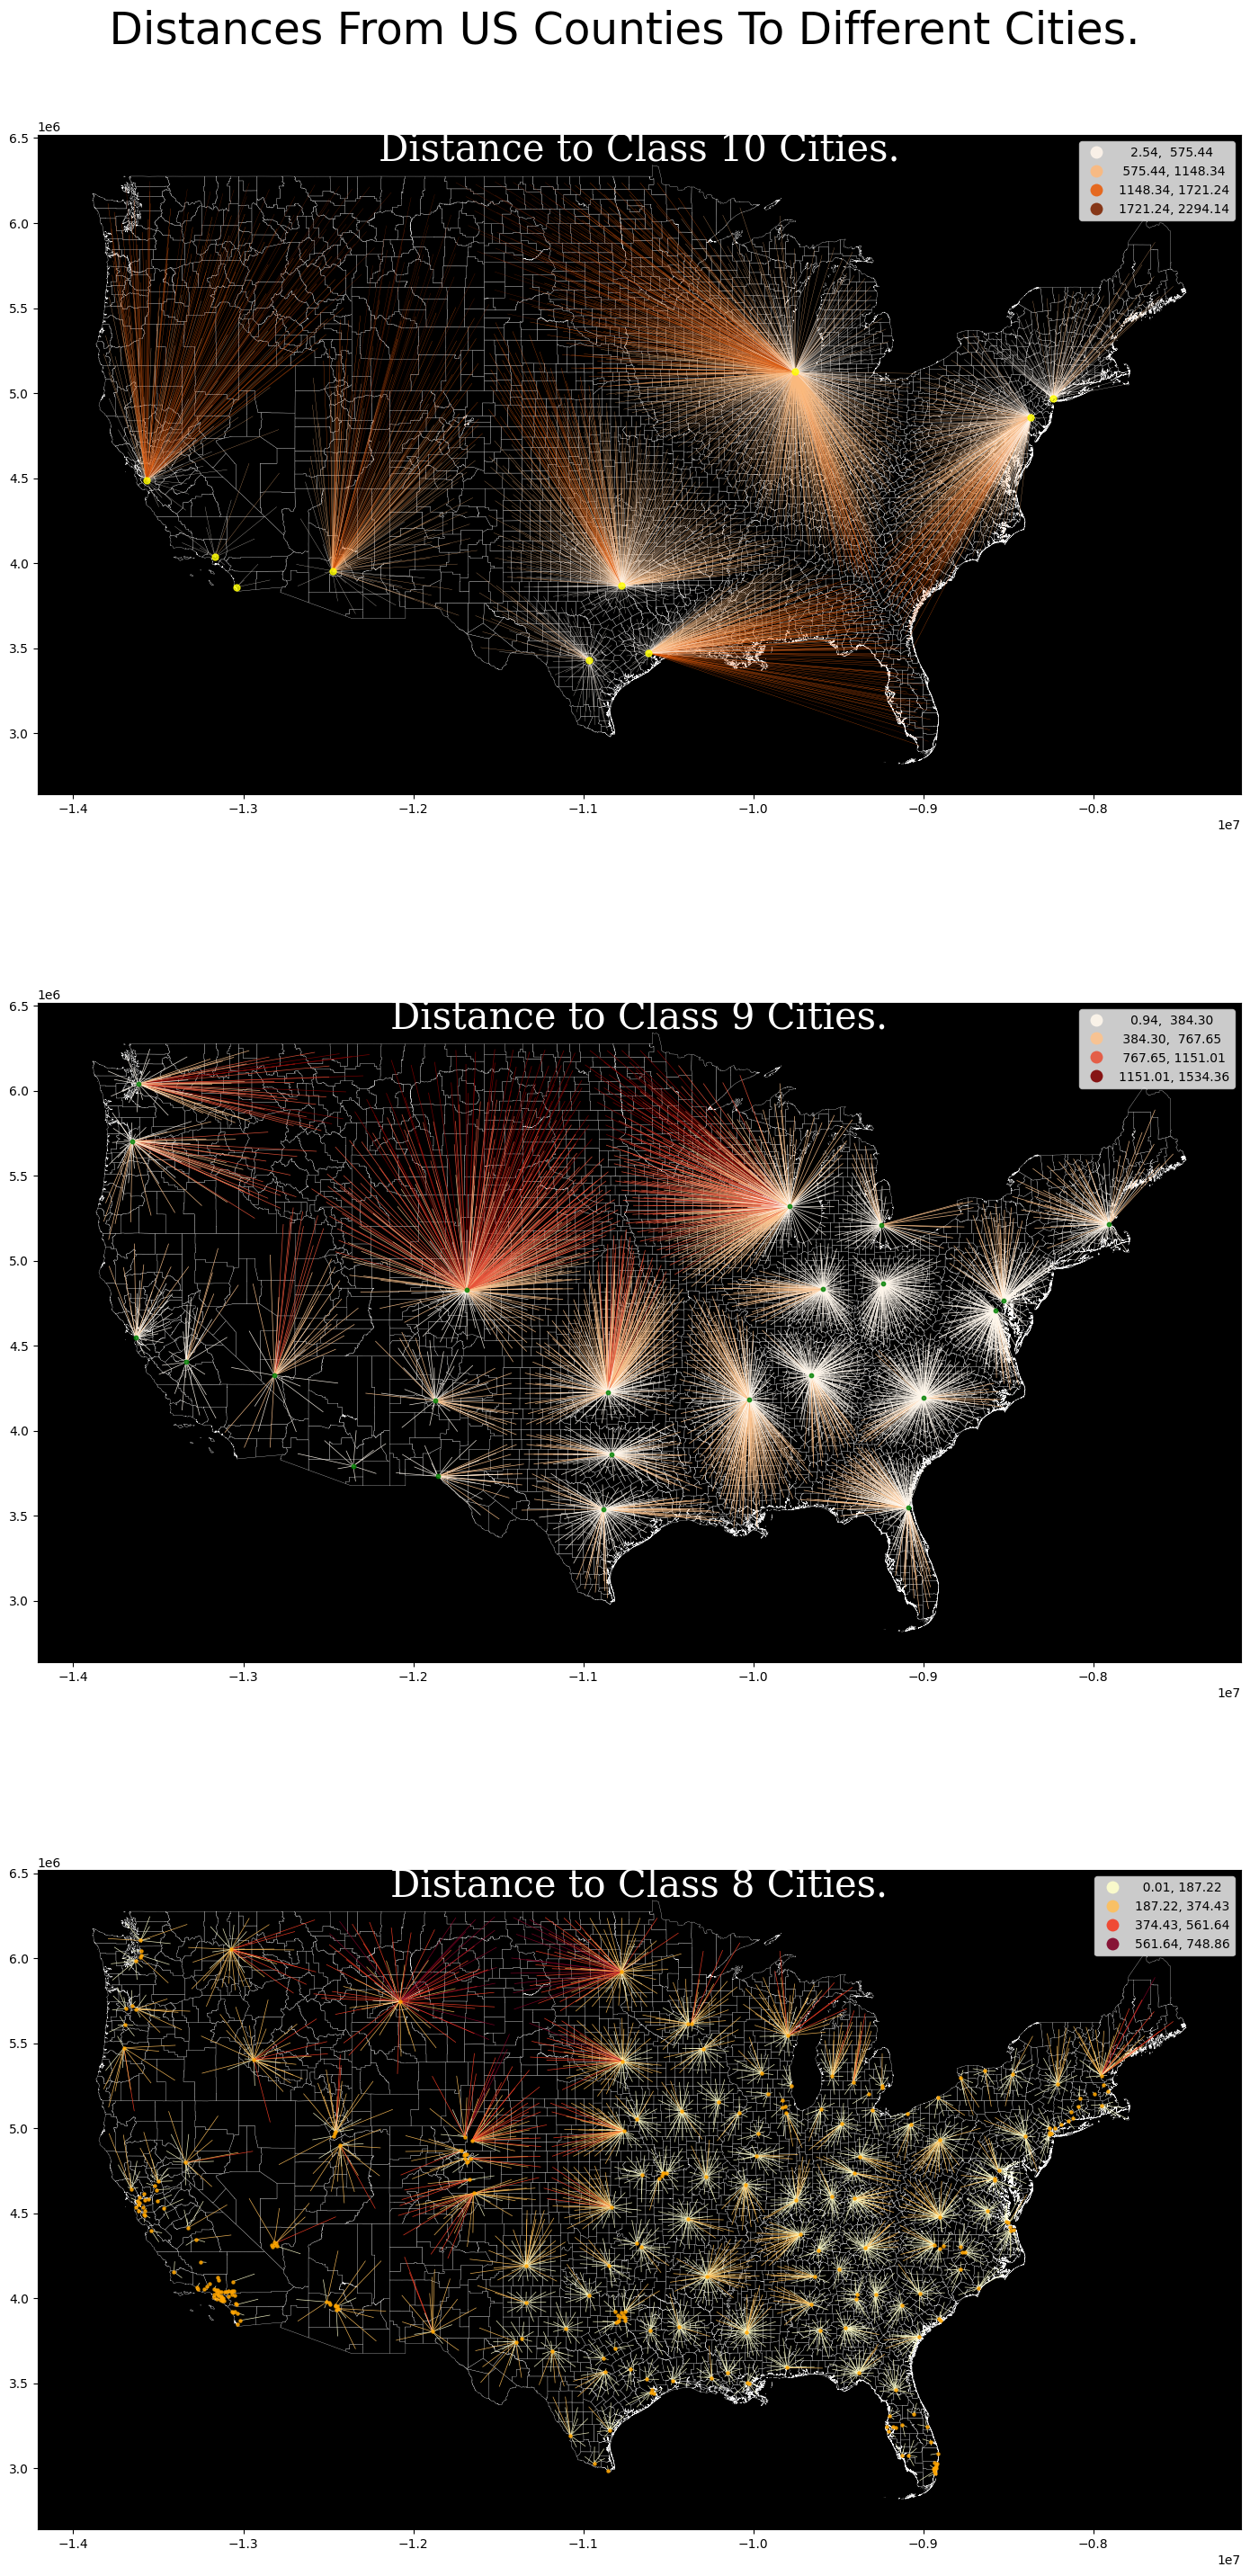

In [10]:
# Visualise all city classes 

# Create line strings between center of polygons to all city classes
data2['link_10'] = data2.apply(lambda row: LineString([row['centroid_county'], row['geometry_point_10']]), axis=1)
data2['link_9'] = data2.apply(lambda row: LineString([row['centroid_county'], row['geometry_point_9']]), axis=1)
data2['link_8'] = data2.apply(lambda row: LineString([row['centroid_county'], row['geometry_point_8']]), axis=1)



# Set distance geometry as the active geometry will be overlayed in final map  
merged_links = data2.copy()
merged_links10 = merged_links.set_geometry('link_10')
merged_links9 = merged_links.set_geometry('link_9')
merged_links8 = merged_links.set_geometry('link_8')


# initiate plot 
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(14, 30))
# Add title to major plot 
fig.suptitle(' Distances From US Counties To Different Cities. ', fontsize=35)


# Class 10 cities 
data2.plot(ax=axes[0],                  # First axis 
           color='black',               # Colour fill of polygon
           edgecolor='white',           # Boundary colour
           linewidth=0.2,               # Boundary width
           alpha=1,                     # Transparency of fill colour 
           label='County')              # Legend label
merged_links10.plot(ax=axes[0], 
                    column='distances_10',        # colour based on column
                    cmap = 'Oranges',             # Colourmap
                    scheme= "equalinterval",      # Classification scheme
                    k=4, 
                    linewidth=0.2, 
                    alpha=0.9, label='Distance', 
                    zorder=1,                     # drawing order 
                    legend=True)
cities_10.plot(ax=axes[0], marker='o', color='yellow', markersize = 25, alpha=0.8, label='Class 10', zorder=2)
axes[0].set_title("Distance to Class 10 Cities.", fontweight="medium", size=30, y=0.95, color='white'
                  , fontfamily='serif')
axes[0].set_facecolor('black')


# Class 9 cities 
data2.plot(ax=axes[1], color='black', edgecolor='white', linewidth=0.2, alpha=1, label='County')
merged_links9.plot(ax=axes[1], column='distances_9', cmap = 'OrRd', scheme= "equalinterval", k=4, 
                linewidth=0.5, alpha=0.9, label='Distance', zorder=1, legend=True)
cities_9.plot(ax=axes[1], marker='o', color='green', markersize = 10, alpha=0.8, label='Class 9', zorder=2)
axes[1].set_title("Distance to Class 9 Cities.", fontweight="medium", size=30, y=0.95, color='white'
                  , fontfamily='serif')
axes[1].set_facecolor('black')


# Class 8 cities 
data2.plot(ax=axes[2], color='black', edgecolor='white', linewidth=0.2, alpha=1, label='County')
merged_links8.plot(ax=axes[2], column='distances_8', cmap = 'YlOrRd', scheme= "equalinterval", k=4,
                 linewidth=0.5, alpha=0.9, label='Distance', zorder=1, legend=True)
cities_8.plot(ax=axes[2], marker='o', color='orange', markersize = 5, alpha=0.8, label='Class 8', zorder=2)
axes[2].set_title("Distance to Class 8 Cities.", fontweight="medium", size=30, y=0.95, color='white'
                  , fontfamily='serif')
axes[2].set_facecolor('black')

# set spacing
fig.tight_layout()
plt.show()


## 3. Encoding Geographical Data.

Another key feature that should be analysed on the model is the geographical(state) designation of a county. We must figure a way to include this categorical data into the algorithm so as to view the potential impact. The biggest challenge is turning textual information i.e 'Rust Belt', 'Plains' to a more meaningfull numeriacl data that is understood by the model. There are multiple methods used to encode data, a simple one is label encoding that simply converts a variable into a number. From our data, there are 8 regions meaning each row will be assigned 8 new  attributes. This technique provides a more compacted data but runs the risk if 'misinterpretation' by the model, i.e if a county is assigned a value 0 and another given 7, the algorithm will easily assign the later more weight, 7X,  causing huge misrepresentation of real life data. 

To solve this problem, we will take a commonly used design method, One Hot Encoding. It simply converts a value to binary values either 1(true) or 0(false). The downside to this algorithm, is that it results to more variables in the dataset increasing complexity. For our data 8 more variable will be added because there are as much unique values. 

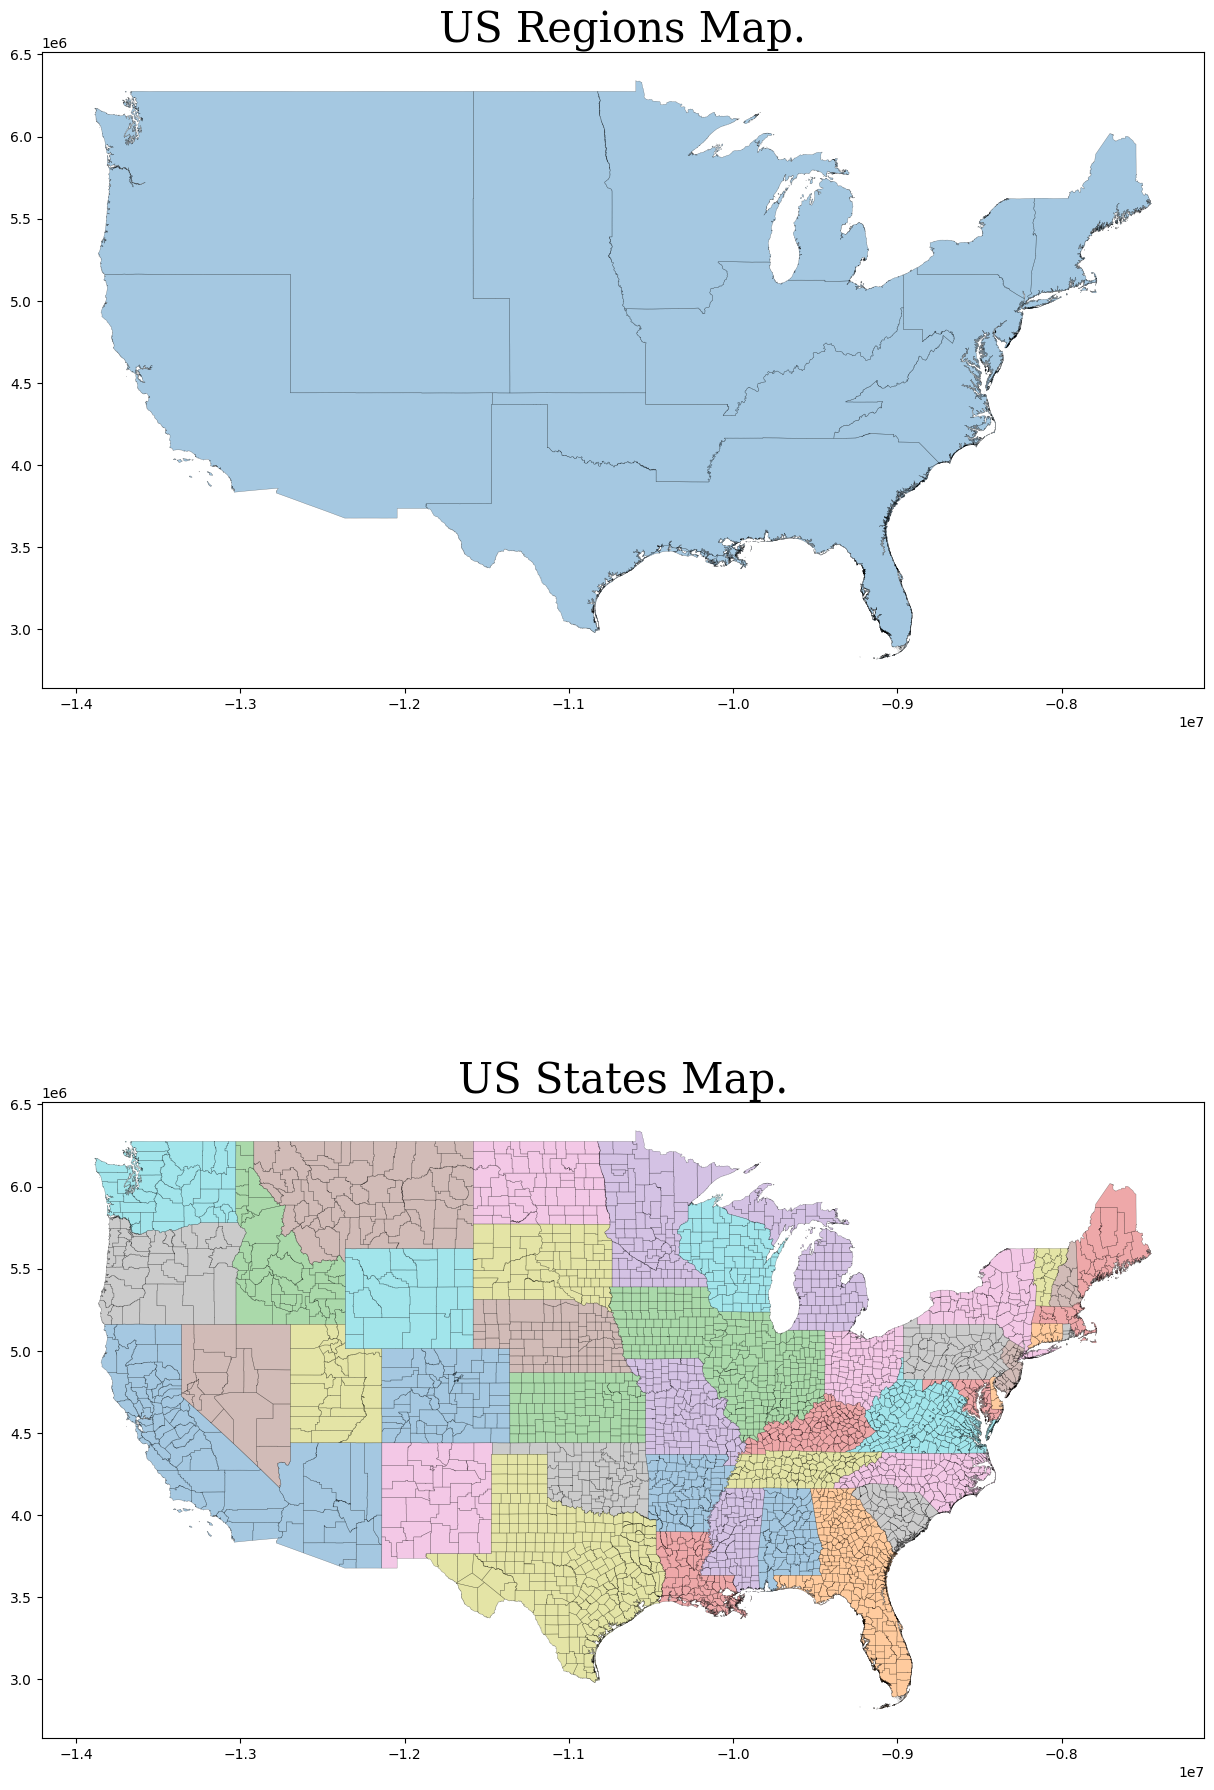

In [13]:
# Visualise regions 

# Plot data  
fig, ax = plt.subplots(nrows=2, ncols=1, sharey=True, figsize=(15, 25))

# Regions
regions.plot(    legend=False,
                ax=ax[0],
                edgecolor='black', linewidth=0.3, alpha=0.4)

# States 
data.plot(column='state_name',        # Colour based on state 
                #categorical=True,
                legend=False,
                ax=ax[1],
                edgecolor='black', linewidth=0.3, alpha=0.4)

# # Remove Axis 
# ax.set_axis_off()

# Title 
ax[0].set_title("US Regions Map.", fontweight="medium", size=30, color='black', fontfamily='serif')
ax[1].set_title("US States Map.", fontweight="medium", size=30, color='black', fontfamily='serif')

plt.show()

In [64]:
# Subset column 

# Initialize OneHotEncoder by calling the function that encodes data to binary column
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')

# Apply one-hot encoding to the categorical columns
one_hot_encoded = encoder.fit_transform(data2[['region']])

print(one_hot_encoded)

      region_East Coast  region_Greater Appalachia  region_Plains  \
0                   0.0                        0.0            0.0   
1                   0.0                        0.0            0.0   
2                   0.0                        0.0            0.0   
3                   0.0                        0.0            0.0   
4                   0.0                        0.0            0.0   
...                 ...                        ...            ...   
3103                0.0                        0.0            0.0   
3104                0.0                        0.0            0.0   
3105                0.0                        0.0            0.0   
3106                0.0                        0.0            0.0   
3107                0.0                        0.0            0.0   

      region_Rust Belt  region_South  region_Southwest  region_Upper Midwest  \
0                  0.0           1.0               0.0                   0.0   
1          

# 4. Feature Scalling.

Pre-processing operation prior to modelling can be a tedious task. A machine learning engineer needs to transfrom data to a format and structure that provides a predictive model condusive enviroment free of errors. Remember these models have different assumptions about the data that and may greatly impact outputs of non-consistent or incompatible data. Feature scalling transforms a numerical features into a common scale by normalising a distribution thus reducing potential biases arising from variations. It also improve the predictive ability of a model by ensuring no single variable has an unwarranted domination in the learning algorithm's output. By scaling the features, we can ensure that they contribute equally to the model’s performance. In some cases, this steps ensures there is a higher levels of convergence speed and performance during modelling. For this study, we will use normalisation technique which transforms feature to values between 1 and 0. 

In [74]:
# Model features information 

print(f'Data information : \n {data2.info()} \n----------------\n\n')    # View data type and missing values 
print(f'Basic statistics : \n {data2.describe().round(2)}')              # Distribution of data 

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3108 entries, 0 to 3107
Data columns (total 32 columns):
 #   Column                                   Non-Null Count  Dtype   
---  ------                                   --------------  -----   
 0   county_FIPS                              3108 non-null   object  
 1   name                                     3108 non-null   object  
 2   population                               3108 non-null   int64   
 3   state_abbr                               3108 non-null   object  
 4   state_fips                               3108 non-null   object  
 5   state_name                               3108 non-null   object  
 6   voter_turnout_2008                       3108 non-null   float64 
 7   voter_turnout_2012                       3108 non-null   float64 
 8   voter_turnout_2016                       3108 non-null   float64 
 9   voter_turnout_2020                       3108 non-null   float64 
 10  2022_median_age             

Index(['population', 'voter_turnout_2008', 'voter_turnout_2012',
       'voter_turnout_2016', '2022_median_age', '2022_per_capitalincome',
       'perc_2022_age_25+_no_diploma/highschool',
       'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income',
       'lifemode_5', 'distances_10', 'distances_9', 'distances_8'],
      dtype='object')


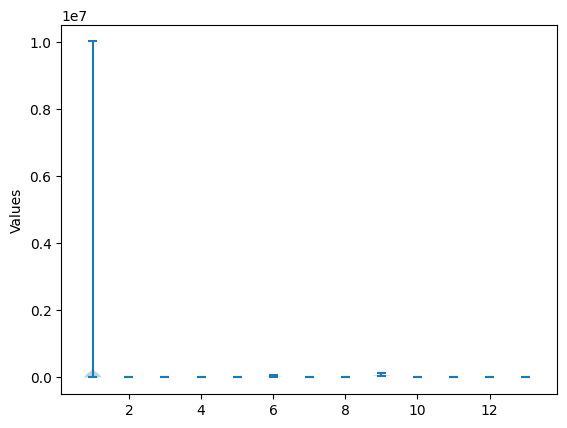

In [79]:
# From the above statistics, our data has no missing values we can thus plot numeric values(float and int objects)
# to understand more about distribution 

# Select numeric values that will be used as predictors 
X = data2.select_dtypes(include=['int64', 'float']).drop('voter_turnout_2020', axis=1)
print(X.columns)

# Data distribution before scalling , Violin plots 
plt.violinplot(X)
plt.ylabel('Values')
plt.show()


In [80]:
# Scaler data through normalisation 

scaleMinMax = MinMaxScaler(feature_range=(0, 1))  # Scaler ensures values should range between 0 and 1 

X = scaleMinMax.fit_transform(X)

# Create a dataframe of scaled data 
X = pd.DataFrame(X, columns=['population', 'voter_turnout_2008', 'voter_turnout_2012','voter_turnout_2016', 
                            '2022_median_age', '2022_per_capitalincome', 'perc_2022_age_25+_no_diploma/highschool',
                             'perc_2022_age_25+_with_bachelors_degree', '2022_avg_disposable_income', 'lifemode_5',
                             'distances_10', 'distances_9', 'distances_8'])

# View Scaled data 
print(f'Scaled data features  : \n {X.describe().round(4)}')

Scaled data features  : 
        population  voter_turnout_2008  voter_turnout_2012  voter_turnout_2016  \
count   3108.0000           3108.0000           3108.0000           3108.0000   
mean       0.0106              0.5103              0.4900              0.5085   
std        0.0337              0.1136              0.1160              0.1101   
min        0.0000              0.0000              0.0000              0.0000   
25%        0.0011              0.4334              0.4095              0.4344   
50%        0.0026              0.5144              0.4889              0.5103   
75%        0.0068              0.5865              0.5685              0.5818   
max        1.0000              1.0000              1.0000              1.0000   

       2022_median_age  2022_per_capitalincome  \
count        3108.0000               3108.0000   
mean            0.4800                  0.2767   
std             0.1267                  0.1096   
min             0.0000                  0.00

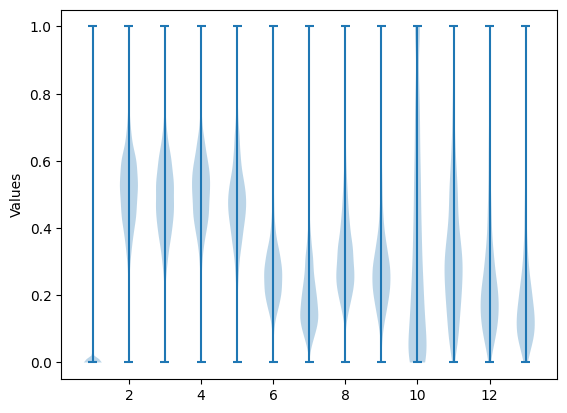

In [82]:
# Plot scaled data 
plt.violinplot(X)
plt.ylabel('Values')
plt.show()



# 6. Predict Voter Turnout. 

Concatenate encoded, normalised and target data  then create an algorithm that will predictt 2020 voter turnout using these newly created features. 

In [83]:

# Target data
y = data2[['voter_turnout_2020']]

# Merge all data to one dataframe 
model1_df = pd.concat([X, one_hot_encoded, y], axis=1)

# View data 
model1_df

population  voter_turnout_2008  voter_turnout_2012  voter_turnout_2016  \
0       0.005866            0.529006            0.501066            0.524248   
1       0.023138            0.529189            0.503348            0.516431   
2       0.002512            0.447389            0.462296            0.426922   
3       0.002220            0.377695            0.368200            0.397302   
4       0.005899            0.498691            0.476412            0.519080   
...          ...                 ...                 ...                 ...   
3103    0.004215            0.465019            0.449833            0.466628   
3104    0.002323            0.773839            0.648562            0.704914   
3105    0.002036            0.499511            0.501641            0.523432   
3106    0.000761            0.601226            0.578760            0.544798   
3107    0.000676            0.515691            0.524642            0.573806   

      2022_median_age  2022_per_capitalincome  \
0            0.397163                0.270316   
1            0.496454                0.347878   
2            0.427896                0.141361   
3            0.413712                0.173247   
4            0.449173                0.214701   
...               ...                     ...   
3103         0.312057                0.345095   
3104         0.397163                0.623663   
3105         0.321513                0.279254   
3106         0.494090                0.245846   
3107         0.505910                0.284696   

      perc_2022_age_25+_no_diploma/highschool  \
0                                    0.208208   
1                                    0.155100   
2                                    0.466807   
3                                    0.359083   
4                                    0.267351   
...                                       ...   
3103                                 0.090827   
3104                                 0.039228   
3105                                 0.074834   
3106                                 0.126433   
3107                                 0.059143   

      perc_2022_age_25+_with_bachelors_degree  2022_avg_disposable_income  \
0                                    0.364723                    0.309028   
1                                    0.473574                    0.353187   
2                                    0.180369                    0.126760   
3                                    0.150378                    0.200708   
4                                    0.200503                    0.236483   
...                                       ...                         ...   
3103                                 0.367240                    0.412877   
3104                                 0.899748                    0.662605   
3105                                 0.276636                    0.350417   
3106                                 0.388003                    0.235545   
3107                                 0.333893                    0.317867   

      lifemode_5  ...  distances_8  region_East Coast  \
0         0.0716  ...     0.057533                0.0   
1         0.1150  ...     0.049438                0.0   
2         0.0537  ...     0.121496                0.0   
3         0.0000  ...     0.106208                0.0   
4         0.1006  ...     0.087736                0.0   
...          ...  ...          ...                ...   
3103      0.0939  ...     0.481836                0.0   
3104      0.0257  ...     0.495079                0.0   
3105      0.2421  ...     0.225038                0.0   
3106      0.4732  ...     0.412195                0.0   
3107      0.8036  ...     0.659734                0.0   

      region_Greater Appalachia  region_Plains  region_Rust Belt  \
0                           0.0            0.0               0.0   
1                           0.0            0.0               0.0   
2                           0.0            0.0       

In [85]:
# Define training features by spliting data then fit a model  



# Predictor variables 
X = model1_df.drop(columns='voter_turnout_2020')

# Define labels 
y = model1_df[['voter_turnout_2020']]

In [98]:
# Split the data into training(70%) and testing data(30%) ,pick random rows
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=6)

# Random forest regressor 
rf1 = RandomForestRegressor(n_estimators=10,    # Number of tress 
                            random_state=21, 
                            oob_score=True     # Validation , estimates the model’s generalization performance
                            )

# Fit regressor
rf1.fit(X_train, y_train)

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=10, oob_score=True, random_state=21)

The main advantage that the OOB score offers is that here the validation data is not seen by the bagging algorithm and that is why the results on the OOB score are the true results that indicated the actual performance of the bagging algorithm.

To get the OOB score of the particular Random Forest algorithm, one needs to set the value “True” for the OOB_Score parameter in the algorithm.

In [101]:
# Evaluation models training and test performance 

# Access the OOB Score
oob_score = rf1.oob_score_
print(f'Out-of-Bag Score: {oob_score} \n')
 
# Making predictions on the same data or new data
predictions_train = rf1.predict(X_train)
predictions_test = rf1.predict(X_test)
 
# Evaluating the model
mse_train = mean_squared_error(y_train, predictions_train)
mse_test = mean_squared_error(y_test, predictions_test)
print(f'Mean Squared Error on train data : {mse_train}')
print(f'Mean Squared Error on test data : {mse_test} \n--------------\n')
 
r2_train = r2_score(y_train, predictions_train)
r2_test = r2_score(y_test, predictions_test)

print(f'R-squared for training data : {r2_train}')
print(f'R-squared for test data : {r2_test}')

Out-of-Bag Score: 0.4546260203354612 

Mean Squared Error on train data : 0.0002724288903578736
Mean Squared Error on test data : 0.001496522629916284 
--------------

R-squared for training data : 0.9712432903253568
R-squared for test data : 0.8376715409994746


In [103]:
print("Feature importances:\n{}".format(rf1.feature_importances_))

Feature importances:
[1.92768960e-02 1.35113574e-02 1.67863191e-02 8.36168762e-01
 1.84356273e-02 1.47571056e-02 9.15685660e-03 9.39298737e-03
 1.42248148e-02 6.40985328e-03 1.30759381e-02 8.81726381e-03
 8.60754997e-03 1.19178964e-03 9.92813884e-04 5.33568939e-04
 2.27975509e-03 2.19135249e-03 2.79339951e-04 4.47191985e-04
 3.46285649e-03]


In [104]:
# Plot the best 15 features 

def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame of features using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=df['feature_importance'], y=df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

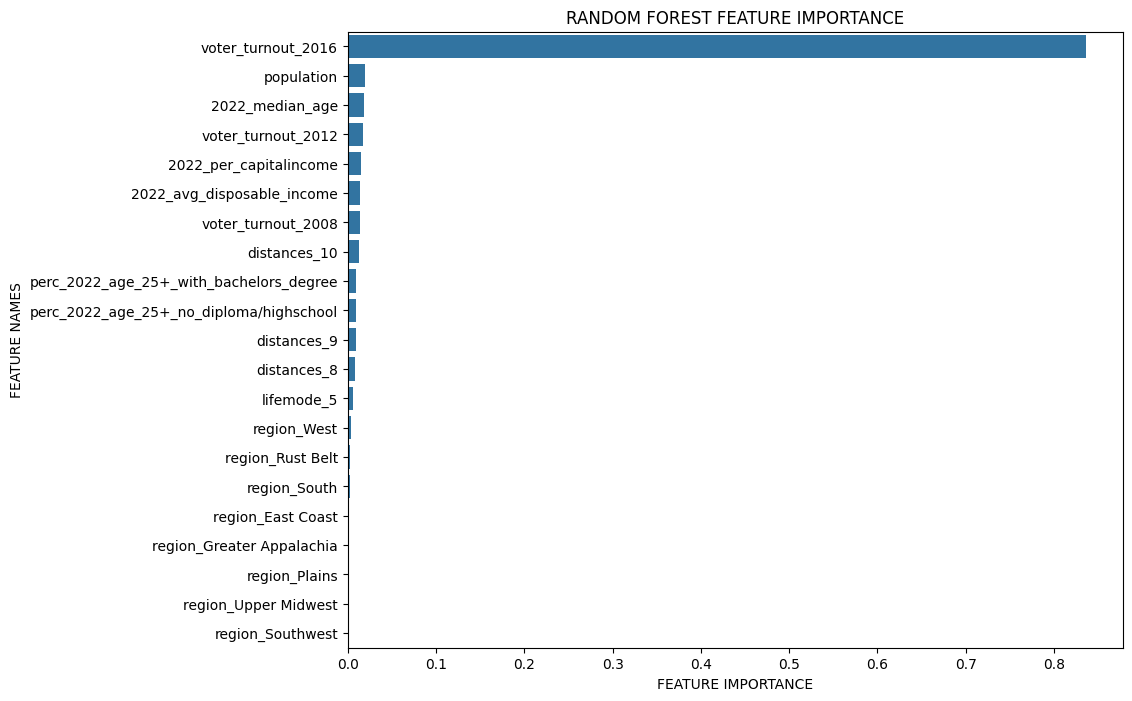

In [105]:
plot_feature_importance(rf1.feature_importances_, X.columns,'RANDOM FOREST')